In [ ]:
FRAME_SIZE = 150
HOP_RATIO = 0.1
N_FFT = 1024
VIGILANCE = 2

In [2]:
import importlib
import modules.AudioProcessor
importlib.reload(modules.AudioProcessor)
from modules.AudioProcessor import AudioProcessor

audio_files = [
    './dataset/trimmed_crowd_talking.mp3',
    './dataset/trimmed_motor_riding.mp3',
    './dataset/trimmed_water_flowing.mp3'
]
ap = AudioProcessor(
    audio_files, 
    frame_size_ms=FRAME_SIZE, 
    hop_length_ratio=HOP_RATIO
    )
print(ap.frames.shape)
print(ap.class_ids.shape)
print(ap.timestamps.shape)

torch.Size([2664, 7200])
(2664,)
(2664,)


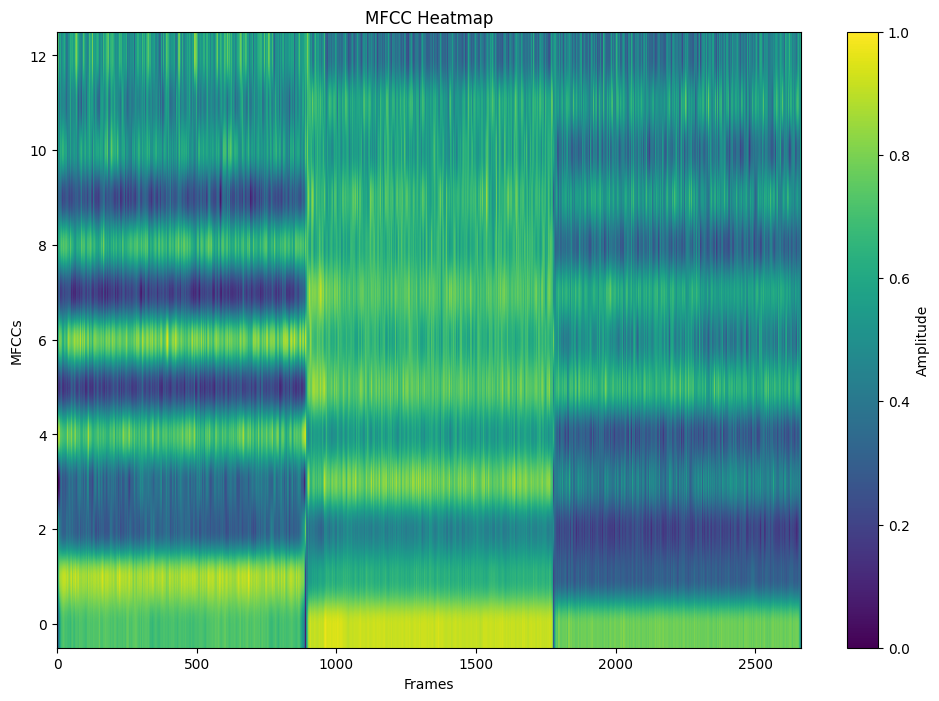

torch.Size([2664, 13])

In [3]:
from modules.FeatureExtractor import FeatureExtractor

fe = FeatureExtractor(n_fft=N_FFT)
fe.extract_mfcc(ap.frames)
fe.plot_mfccs()
fe.mfcc_features.shape

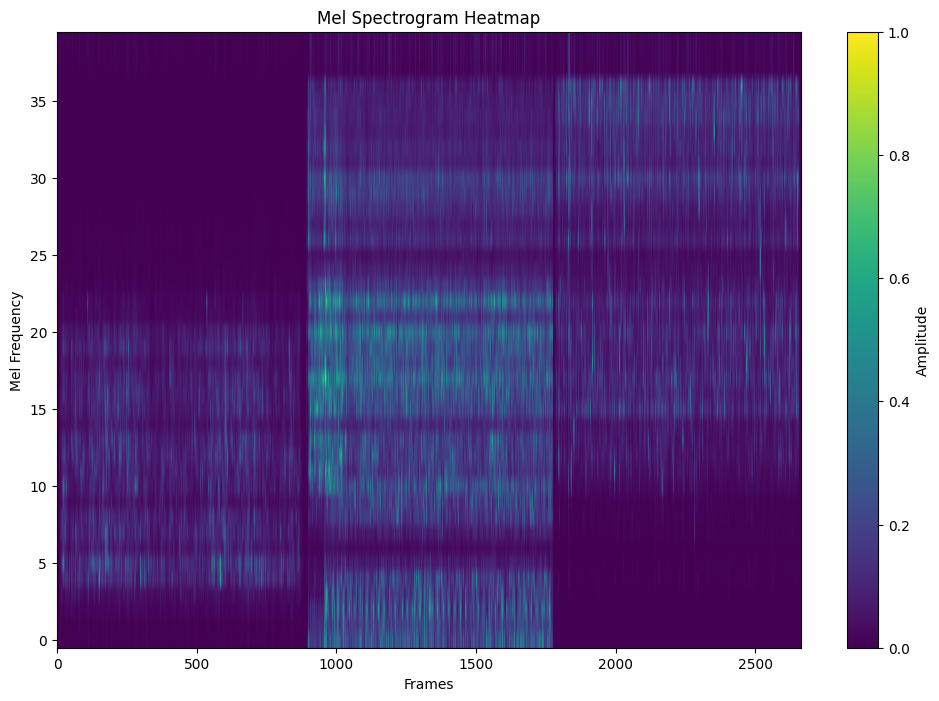

torch.Size([2664, 40])

In [4]:
fe.extract_melspectrogram(ap.frames)
fe.plot_melspectrogram()
fe.melspectrogram_features.shape

In [9]:
important_mfcc_features = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11]
important_mfsc_features = [i for i in range(14)] + [i for i in range(16, 35)]
n_features = len(important_mfcc_features) + len(important_mfsc_features)

import importlib
import modules.DatasetHandler
importlib.reload(modules.DatasetHandler)
from modules.DatasetHandler import DatasetHandler

dh = DatasetHandler(
    ap.class_ids,
    ap.timestamps, 
    fe.mfcc_features, 
    fe.melspectrogram_features, 
    len(important_mfcc_features) + len(important_mfsc_features)
)
dh.generate_all_features_csv()
dh.save_selected_features(important_mfcc_features, important_mfsc_features)

time_series_tensor = dh.generate_time_series()

c:\Users\Kennan\projects\online-clustering\modules\DatasetHandler.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  time_series_data = pd.concat([time_series_data, selected_rows], ignore_index=True)
c:\Users\Kennan\projects\online-clustering\modules\DatasetHandler.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  time_series_data = pd.concat([time_series_data, selected_rows], ignore_index=True)
c:\Users\Kennan\projects\online-clustering\modules\DatasetHandler.py:87: FutureWarning: The beha

c:\Users\Kennan\projects\online-clustering\modules\ART2Clusterer.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, pd.DataFrame([data])], ignore_index=True)


[[1768    0    0]
 [1760    0    0]
 [1760    0    0]]
0.33434190620272314


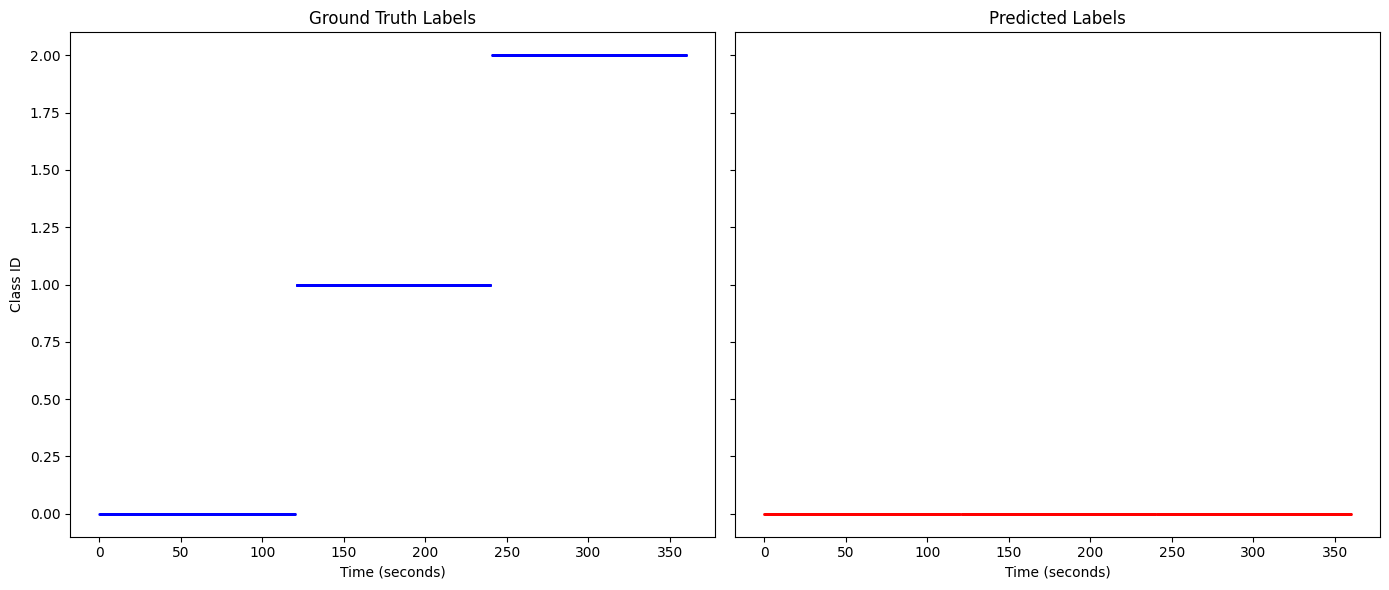

c:\Users\Kennan\projects\online-clustering\modules\ART2Clusterer.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, pd.DataFrame([data])], ignore_index=True)


In [ ]:
import modules.ART2Clusterer
importlib.reload(modules.ART2Clusterer)
from modules.ART2Clusterer import ART2Clusterer
import pandas as pd

for i in range(5):
    df = pd.read_csv(f'output/time_series_{i}/ground_truth_{i}.csv')
    clusterer = ART2Clusterer(
        vigilance=VIGILANCE, 
        n_features=n_features,
        time_series_index=i
    )
    for index, row in df.iterrows():
        clusterer.fit_clusters(row)

    clusterer.write_to_csv()
    conf_matrix, acc = clusterer.calc_accuracy()
    print(conf_matrix)
    print(acc)
    clusterer.plot_truth_vs_time()

In [ ]:
from modules.PCA import PCA

pca = PCA('output/selected_features.csv')
dh.generate_pca_csv(pca.projected_data)

time_series_tensor = dh.generate_time_series(
    FRAME_SIZE, 
    HOP_RATIO, 
    filename="pca_features.csv", 
    output_folder="PCA_time_series"
)

pca.projected_data.shape

In [ ]:
VIGILANCE_PCA = 200

for i in range(5):
    df = pd.read_csv(f'output/PCA_time_series_{i}/ground_truth_{i}.csv')
    clusterer = ART2Clusterer(
        vigilance=VIGILANCE_PCA, 
        n_features=pca.projected_data.shape[1],
        time_series_index=i,
        predicted_filename_prefix="PCA_time_series"
    )
    for index, row in df.iterrows():
        clusterer.fit_clusters(row)

    clusterer.write_to_csv()
    conf_matrix, acc = clusterer.calc_accuracy()
    print(conf_matrix)
    print(acc)
    clusterer.plot_truth_vs_time()